In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import meals
from foods.dashboard import (
    read_database,
    find_item, 
    make_data, meal_plots,
    nuts_plots,
    staple_plots
)

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

foods = read_database()

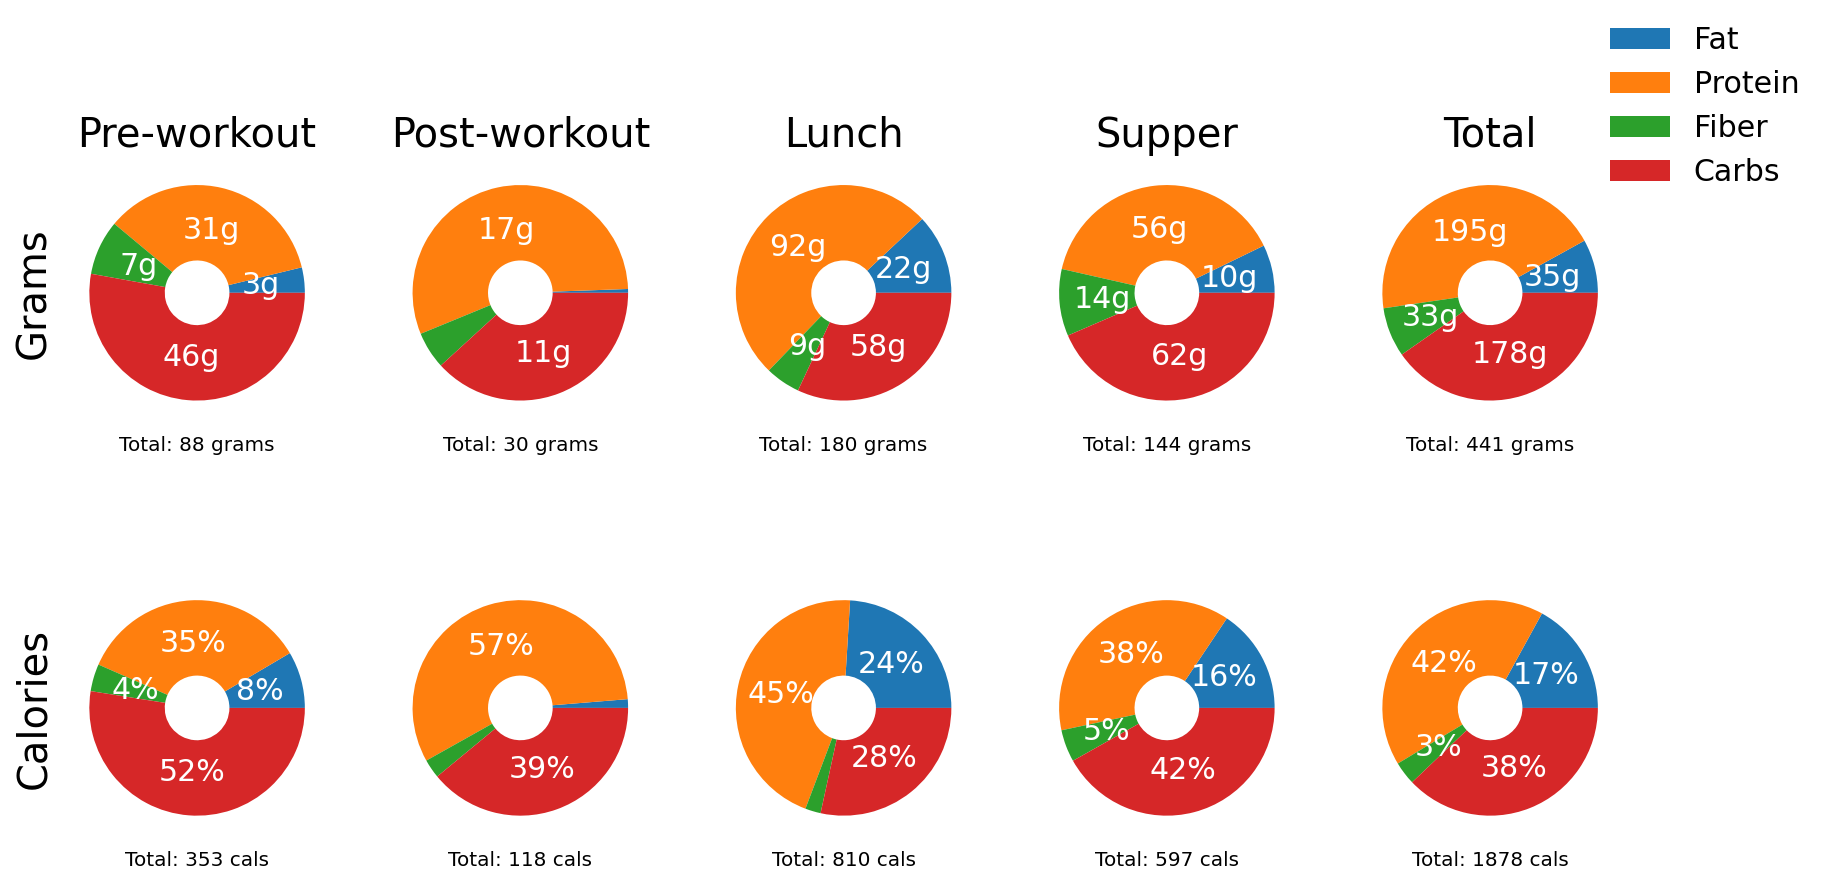

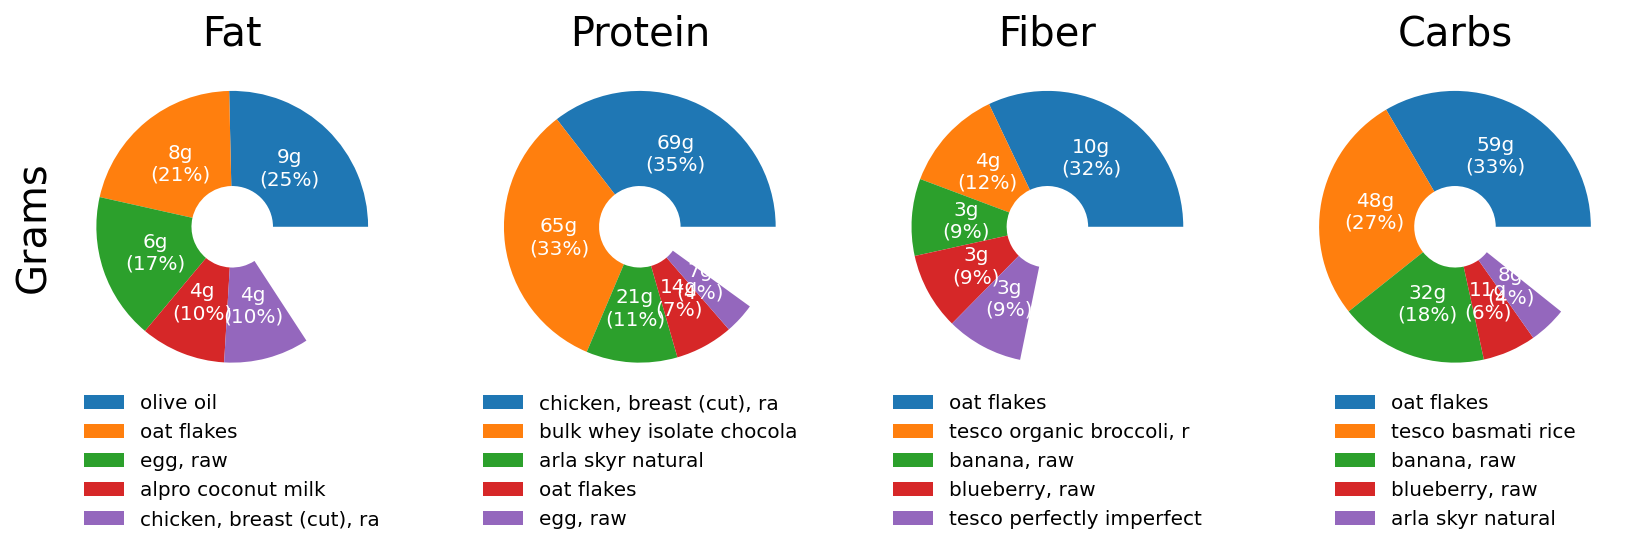

In [7]:
meal_data = make_data(meals.sep17_2021, foods)
meal_plots(meal_data)
nuts_plots(meal_data)

## Foods finder

In [3]:
find_item('kikko', foods)

,ingredient,category,fat,carbs,sugar,fiber,protein
1048,kikkoman less salt soy sauce,added,0.0,6.9,3.9,0.0,9.7
